# Wines Points prediction 

#### Import Libraries and Packages

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

In [2]:
import string
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/urielkornfein/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/urielkornfein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/urielkornfein/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [6]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [7]:
# import pandas as pd
# import cufflinks as cf; cf.go_offline()

In [8]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [9]:
wine_reviews.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [10]:
wine_reviews.sample(5)

Unnamed: 0 country                                        description  \
108587      108587   Spain  Even the very best Txakoli won't appeal to eve...   
47047        47047  France  Starts off scents with toasted hazelnut that g...   
105999      105999      US  Meritage wines must be Bordeaux blends; otherw...   
74529        74529   Italy  From near the Tuscan coast comes this Bordeaux...   
52455        52455      US  Great balance in this fruit-forward yet well-s...   

                 designation  points  price        province  \
108587                   NaN      83   25.0  Northern Spain   
47047   Domaine Mule Blanche      89   39.0    Rhône Valley   
105999               Genesis      87   16.0      Washington   
74529               Le Marze      89   40.0         Tuscany   
52455                    NaN      90   18.0      California   

                    region_1         region_2        taster_name  \
108587   Getariako Txakolina              NaN  Michael Schachner   
47047       Crozes-Hermitage              NaN     Joe Czerwinski   
105999  Columbia Valley (WA)  Columbia Valley       Paul Gregutt   
74529                Toscana              NaN  Michael Schachner   
52455       Mendocino County              NaN         Jim Gordon   

       taster_twitter_handle  \
108587           @wineschach   
47047                 @JoeCz   
105999           @paulgwine    
74529            @wineschach   
52455       @gordone_cellars   

                                                    title  \
108587     Txomín Etxaníz 2014 Rosé (Getariako Txakolina)   
47047   Paul Jaboulet Aîné 2007 Domaine Mule Blanche W...   
105999  Hogue 2007 Genesis Meritage (Columbia Valley (...   
74529              Elisabetta 1998 Le Marze Red (Toscana)   
52455          Graziano 2011 Zinfandel (Mendocino County)   

                         variety              winery  
108587                      Rosé      Txomín Etxaníz  
47047    Rhône-style White Blend  Paul Jaboulet Aîné  
105999                  Meritage               Hogue  
74529   Bordeaux-style Red Blend          Elisabetta  
52455                  Zinfandel            Graziano

In [11]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [12]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [13]:
wine_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


In [14]:
#looks like there are na values, however, I'm choosing not to exclude them, as I assume,
#according to the data structure, this won't hurt modeling that much

In [15]:
wine_reviews.title.nunique()

118840

In [16]:
#because there are less titles than rows, it seems some wines are tested twice or more

In [17]:
wine_reviews[wine_reviews.title == wine_reviews.title.value_counts().idxmax()]

country                                        description  \
3209        US  Creamy, lush and somewhat robust, this dry spa...   
4399        US  Made predominantly from Pinot Noir, this is an...   
27773       US  A wonderfully drinkable sparkling wine that ap...   
63179       US  Made from mostly Pinot Noir grapes, with an ad...   
81563       US  This wine shows lots of finesse for the price....   
94321       US  A bit rough and scouring in texture, this tast...   
100738      US  A good, dry and elegant bubbly. Shows crisp fl...   
109001      US  From almost 92% Pinot Noir with the remainder ...   
122208      US  This bubbly is rich in cherry and raspberry fr...   

        designation  points  price    province       region_1 region_2  \
3209    Sonoma Brut      90   22.0  California  Sonoma County   Sonoma   
4399    Sonoma Brut      88   22.0  California  Sonoma County   Sonoma   
27773   Sonoma Brut      90   20.0  California  Sonoma County   Sonoma   
63179   Sonoma Brut      92   22.0  California  Sonoma County   Sonoma   
81563   Sonoma Brut      89   24.0  California  Sonoma County   Sonoma   
94321   Sonoma Brut      85   20.0  California  Sonoma County   Sonoma   
100738  Sonoma Brut      89   20.0  California  Sonoma County   Sonoma   
109001  Sonoma Brut      88   22.0  California  Sonoma County   Sonoma   
122208  Sonoma Brut      86   20.0  California  Sonoma County   Sonoma   

           taster_name taster_twitter_handle  \
3209    Virginie Boone               @vboone   
4399    Virginie Boone               @vboone   
27773              NaN                   NaN   
63179   Virginie Boone               @vboone   
81563              NaN                   NaN   
94321              NaN                   NaN   
100738             NaN                   NaN   
109001  Virginie Boone               @vboone   
122208             NaN                   NaN   

                                                    title          variety  \
3209    Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
4399    Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
27773   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
63179   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
81563   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
94321   Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
100738  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
109001  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   
122208  Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Sparkling Blend   

               winery  
3209    Gloria Ferrer  
4399    Gloria Ferrer  
27773   Gloria Ferrer  
63179   Gloria Ferrer  
81563   Gloria Ferrer  
94321   Gloria Ferrer  
100738  Gloria Ferrer  
109001  Gloria Ferrer  
122208  Gloria Ferrer

In [18]:
#the reviews for the same title are different, based on reviewer and desc, so that should be ok

In [19]:
wine_reviews.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

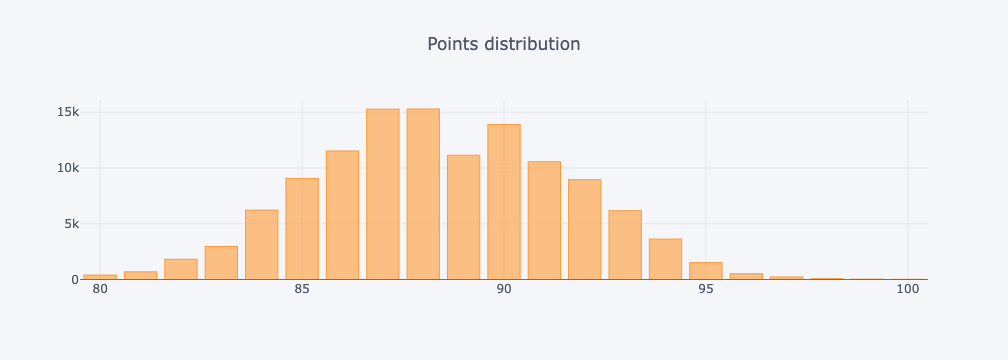

In [20]:
wine_reviews.points.value_counts().iplot(kind='bar', title = 'Points distribution', hline=(0))

In [21]:
#points dist looks normal

#### AVG Score and Price by Country

In [22]:
pd.concat([wine_reviews.country.value_counts().rename('counts'), 
          wine_reviews.country.value_counts().rename('proportion').div(wine_reviews.shape[0])], axis=1).head()

counts  proportion
US         50457    0.420517
France     20353    0.169625
Italy      17940    0.149515
Spain       6116    0.050972
Portugal    5256    0.043804

In [23]:
def calc_average_score_and_price(country_df):
    return pd.Series({'average_price': country_df.price.mean(),
                      'average_score': country_df.points.mean()})

In [24]:
stats_by_country = wine_reviews.groupby('country').apply(calc_average_score_and_price)
stats_by_country.head()

average_price  average_score
country                                             
Argentina                   24.575264      86.649831
Armenia                     14.500000      87.500000
Australia                   35.686491      88.561220
Austria                     31.336751      90.129532
Bosnia and Herzegovina      12.500000      86.500000

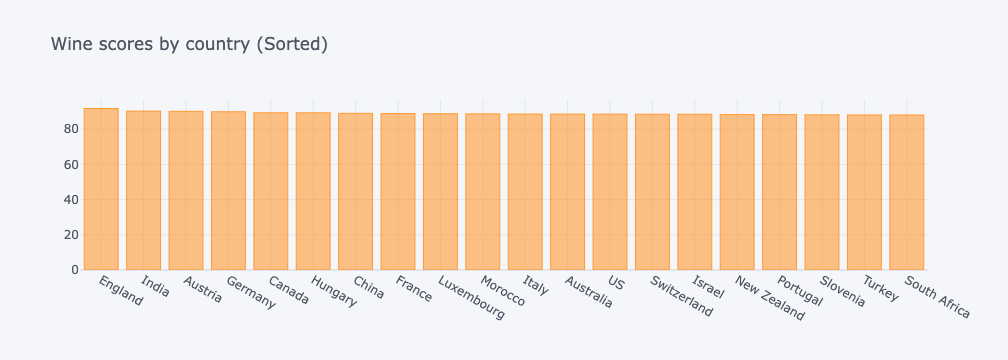

In [25]:
stats_by_country.average_score.sort_values(ascending=False).head(20).iplot(kind='bar', title = 'Wine scores by country (Sorted)')

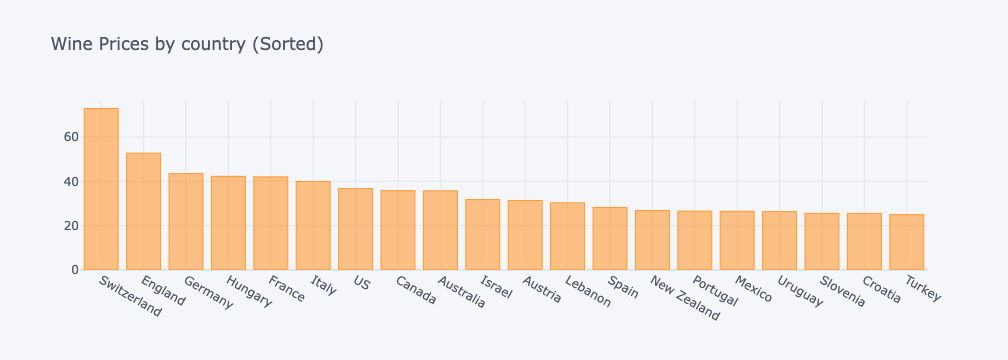

In [26]:
stats_by_country.average_price.sort_values(ascending=False).head(20).iplot(kind='bar', title = 'Wine Prices by country (Sorted)')

#### Is there a clear corrleation between price and points?

In [27]:
wine_reviews[['price','points']].corr(method = 'pearson')

price    points
price   1.000000  0.416534
points  0.416534  1.000000

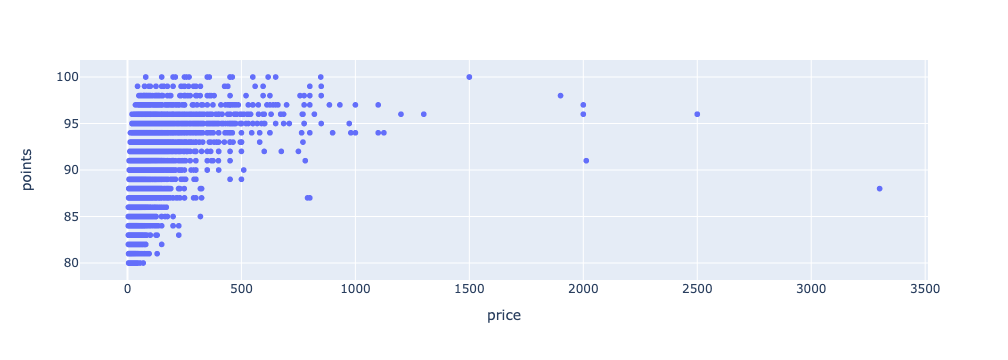

In [28]:
px.scatter(wine_reviews, x='price',y='points')

Because prices are dependent on country, and point aren't, we should breakdown by country

In [29]:
top_ten_countries = wine_reviews.country.value_counts().index[:10]
list(top_ten_countries)

['US',
 'France',
 'Italy',
 'Spain',
 'Portugal',
 'Chile',
 'Argentina',
 'Austria',
 'Australia',
 'Germany']

In [30]:
wine_reviews.groupby('country')[['price','points']].corr(method = 'pearson').loc[top_ten_countries]

price    points
country                             
US        price   1.000000  0.455320
          points  0.455320  1.000000
France    price   1.000000  0.406553
          points  0.406553  1.000000
Italy     price   1.000000  0.531854
          points  0.531854  1.000000
Spain     price   1.000000  0.478852
          points  0.478852  1.000000
Portugal  price   1.000000  0.438125
          points  0.438125  1.000000
Chile     price   1.000000  0.482639
          points  0.482639  1.000000
Argentina price   1.000000  0.571894
          points  0.571894  1.000000
Austria   price   1.000000  0.391295
          points  0.391295  1.000000
Australia price   1.000000  0.468471
          points  0.468471  1.000000
Germany   price   1.000000  0.457733
          points  0.457733  1.000000

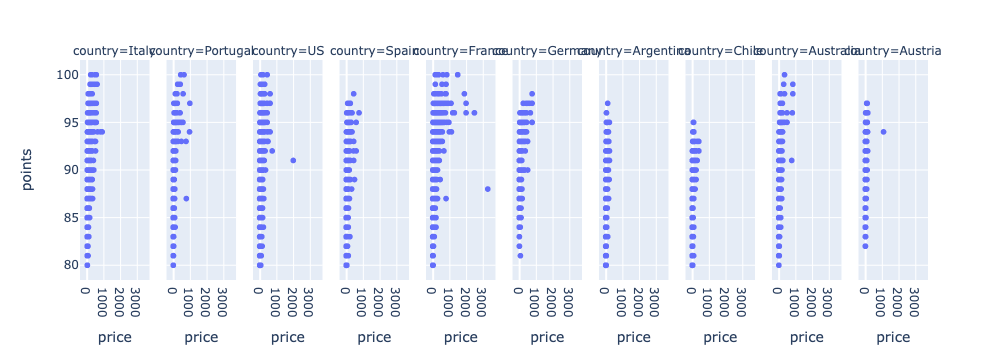

In [31]:
px.scatter(wine_reviews[wine_reviews.country.isin(top_ten_countries)], x='price',y='points',facet_col='country')

we can see that high score doesn't necessarily equal high price

## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [32]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [33]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [34]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [36]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.603218
MAE    2.537841
R2    -0.000018
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [37]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.684285
Armenia                   88.000000
Australia                 88.558338
Austria                   90.196701
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [38]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    9.130190
MAE    2.471840
R2     0.049241
dtype: float64

### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [39]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.800329
           Other               85.985149
Armenia    Armenia             88.000000
Australia  Australia Other     85.451429
           New South Wales     87.666667
Name: basiline_3_predicted_points, dtype: float64

In [40]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 16), (23998, 15))

In [41]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.589486
MAE    2.376368
R2     0.105546
dtype: float64

### Baselines summary

In [42]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

MSE       MAE        R2
baseline_1  9.603218  2.537841 -0.000018
baseline_2  9.130190  2.471840  0.049241
baseline_3  8.589486  2.376368  0.105546

In [43]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
le = LabelEncoder()
scalar=StandardScaler()

#### Preparing data - Lable encoding categorical features

In [45]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [46]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

country  province  region_1  region_2  taster_name  variety  winery  price  \
0       22       332       424         6            9      691   11608   -1.0   
1       32       108       738         6           16      451   12956   15.0   
2       41       269      1218        17           15      437   13018   14.0   
3       41       218       549         6            0      480   14390   13.0   
4       41       269      1218        17           15      441   14621   65.0   

   points  
0      87  
1      87  
2      87  
3      87  
4      87

#### Re-splitting to train and test

In [47]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))
test_encoded_features

country  province  region_1  region_2  taster_name  variety  winery  \
0            22       332       424         6            9      691   11608   
4            41       269      1218        17           15      441   14621   
5            38       263       758         6           12      591   14706   
13           22       332       424         6            9      388   10819   
14           41        51       185         1           11      125   11125   
...         ...       ...       ...       ...          ...      ...     ...   
129938        0       216       589         6           12      280    2758   
129945       41        51       974         1           11      137    1274   
129946       17       232       738         6            1      480    1277   
129951       15        11        21         6           16      209    8439   
129965       15        11        21         6           16      437    6100   

        price  points  
0        -1.0      87  
4        65.0      87  
5        15.0      87  
13       -1.0      87  
14       12.0      87  
...       ...     ...  
129938   25.0      91  
129945   20.0      90  
129946   17.0      90  
129951   30.0      90  
129965   28.0      90  

[23998 rows x 9 columns]

#### Fitting a tree-regressor

In [48]:
from src.models import i_feel_lucky_xgboost_training

In [49]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 1 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int64  
 1   province     95990 non-null  int64  
 2   region_1     95990 non-null  int64  
 3   region_2     95990 non-null  int64  
 4   taster_name  95990 non-null  int64  
 5   variety      95990 non-null  int64  
 6   winery       95990 non-null  int64  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 7.3 MB


In [50]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [51]:
test_encoded_features.head()

country  province  region_1  region_2  taster_name  variety  winery  \
0        22       332       424         6            9      691   11608   
4        41       269      1218        17           15      441   14621   
5        38       263       758         6           12      591   14706   
13       22       332       424         6            9      388   10819   
14       41        51       185         1           11      125   11125   

    price  points  xgb_clf_points_prediction  
0    -1.0      87                         87  
4    65.0      87                         92  
5    15.0      87                         87  
13   -1.0      87                         87  
14   12.0      87                         87

In [52]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

MSE    6.410284
MAE    1.907826
R2     0.332474
dtype: float64

In [53]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

MSE       MAE        R2
baseline_1         9.603218  2.537841 -0.000018
baseline_2         9.130190  2.471840  0.049241
baseline_3         8.589486  2.376368  0.105546
regression_by_xgb  6.410284  1.907826  0.332474

In [54]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

##### Removing stop words and punctuation

In [55]:
stopwords = nltk.corpus.stopwords.words("english") + nltk.corpus.stopwords.words("italian") + nltk.corpus.stopwords.words("spanish") + nltk.corpus.stopwords.words("french")

In [56]:
from src.clean import leave_language_only

In [57]:
#cleaning desc column

train_data['description_clean'] = leave_language_only(train_data.description.str.lower())
test_data['description_clean'] = leave_language_only(test_data.description.str.lower())

In [58]:
all_test_words = [word.lower() for description in train_data.description_clean for word in nltk.word_tokenize(description) if word.lower() not in stopwords and word not in string.punctuation ]
# Words without stop words

#### Creating Vocabulary

In [59]:
words_df = pd.DataFrame(data = all_test_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head(10)

word  wordCount  wordImportance
0     wine      57729        0.000012
1  flavors      46248        0.000015
2    fruit      33268        0.000021
3   aromas      28933        0.000024
4   palate      27854        0.000025
5   finish      25795        0.000027
6  acidity      25596        0.000027
7  tannins      22805        0.000030
8    drink      22064        0.000031
9   cherry      20188        0.000034

we can see that wine, flavors and drink  are improtant but probably add nothing of value as they will repeat in most descriptions.
regardless of the score - so we will remove them by adding them to the stop words.

In [60]:
stopwords.append('wine')
stopwords.append('flavors')
stopwords.append('drink')

In [61]:
all_test_words = [word.lower() for description in train_data.description_clean for word in nltk.word_tokenize(description) if word.lower() not in stopwords and word not in string.punctuation ]

In [62]:
words_df = pd.DataFrame(data = all_test_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head(10)

word  wordCount  wordImportance
0    fruit      33268        0.000036
1   aromas      28933        0.000042
2   palate      27854        0.000043
3   finish      25795        0.000047
4  acidity      25596        0.000047
5  tannins      22805        0.000053
6   cherry      20188        0.000060
7     ripe      19928        0.000060
8    black      18803        0.000064
9    notes      14062        0.000086

In [63]:
print("Total of {} words, {} unique words".format(len(all_test_words), len(words_df)))

Total of 2233532 words, 40083 unique words


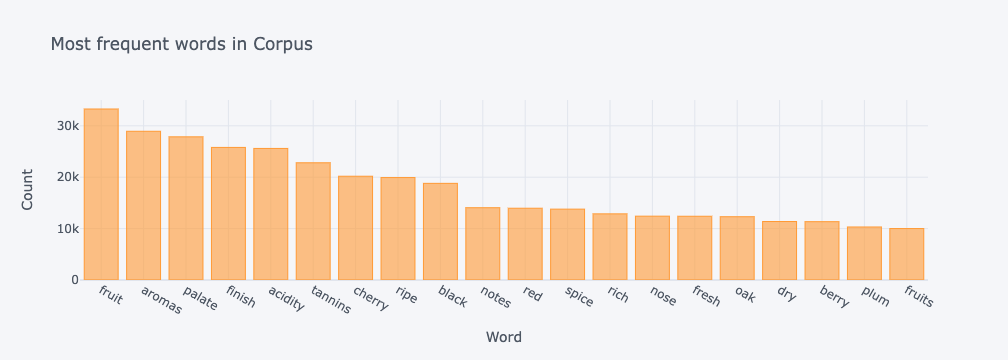

In [64]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [65]:
new_size = words_df[words_df.wordCount >= 10].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 2 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 40083
Using words with 2 or more appearnces will reduce the corpus size to: 8002
propotion of new vocabulary from all training unique words is 0.200
Number of records in training dataset: 95990
features vs records in training dataset: 0.083


In [66]:
new_size = words_df[words_df.wordCount >= 5].shape[0]
tr_size = words_df.shape[0]
tr_rec = train_data.shape[0]
print("Number of unique words in training dataset: {}".format(tr_size))
print("Using words with 5 or more appearnces will reduce the corpus size to: {}".format(new_size))
print(f'propotion of new vocabulary from all training unique words is {new_size/tr_size:.3f}')
print("Number of records in training dataset: {}".format(tr_rec))
print(f'features vs records in training dataset: {new_size/tr_rec:.3f}')

Number of unique words in training dataset: 40083
Using words with 5 or more appearnces will reduce the corpus size to: 11715
propotion of new vocabulary from all training unique words is 0.292
Number of records in training dataset: 95990
features vs records in training dataset: 0.122


In [67]:
words_df = words_df[words_df.wordCount >= 5]

In [68]:
clean_vocab = set(words_df.word)
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)
clean_bow_counts = count_vect.fit_transform(train_data.description_clean)
clean_bow_counts.shape

(95990, 11715)

##### Using train BOW to run a CV on it and find optimal alpha

In [69]:
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
mse_by_alpha = []
for alpha in search_grid:
    model = Ridge( alpha=alpha)
    avg_score = abs(cross_val_score(model, clean_bow_counts, y=train_data.points, cv=10, scoring='neg_mean_squared_error').mean())
    mse_by_alpha.append((alpha,avg_score))

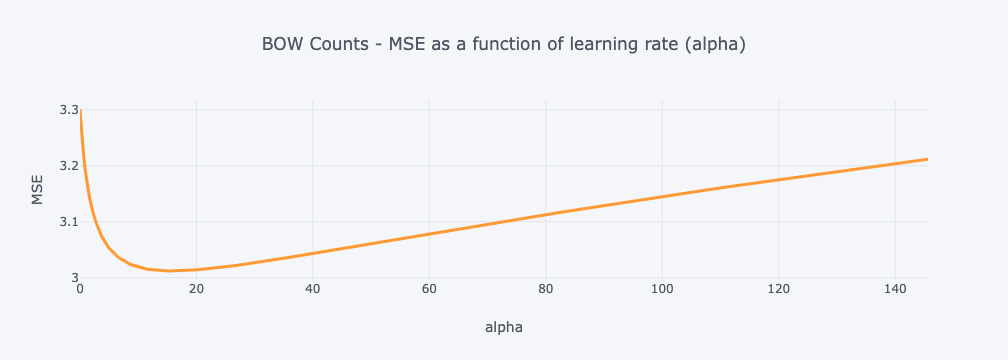

In [70]:
cv_results = pd.DataFrame(mse_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 150').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [71]:
cv_results.sort_values(by='MSE').head(5)

alpha       MSE
26  15.264180  3.011947
27  20.235896  3.014024
25  11.513954  3.015244
28  26.826958  3.021951
24   8.685114  3.023474

In [72]:
opt_alpha, max_auc = cv_results.loc[cv_results.MSE.idxmin()]
print(opt_alpha, max_auc)

15.264179671752334 3.0119472000362455


In [73]:
model = Ridge( alpha=opt_alpha)
model.fit(clean_bow_counts, train_data.points)

Ridge(alpha=15.264179671752334)

In [74]:
clean_bow_counts_test = count_vect.fit_transform(test_data.description_clean)

In [75]:
test_data['predicted_score']= model.predict(clean_bow_counts_test)

In [132]:
bow_stats = calc_prediction_quality(test_data, 'predicted_score', 'points')
bow_stats

MSE    3.009492
MAE    1.367681
R2     0.686611
dtype: float64

#### Creating sparse matrix for BOW + Features

In [77]:
from scipy.sparse import coo_matrix, hstack

train_features_spares_matrix = coo_matrix(train_encoded_features.iloc[:,0:8])
train_united_features = hstack((clean_bow_counts ,train_features_spares_matrix))

test_features_spares_matrix = coo_matrix(test_encoded_features.iloc[:,0:8])
test_united_features = hstack((clean_bow_counts_test ,test_features_spares_matrix))

In [78]:
%%capture
search_grid=[0.001,0.01,0.1,0,1,5,15,50,100,1000]
auc_by_alpha = []
for alpha in search_grid:
    model = Ridge( alpha=alpha,tol=0.00001)
    avg_score = abs(cross_val_score(model, train_united_features, y =train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean())
    auc_by_alpha.append((alpha,avg_score))

In [79]:
auc_by_alpha

[(0.001, 3.3152235654677114),
 (0.01, 3.3133731200303815),
 (0.1, 3.2961926207362198),
 (0, 3.3154180930630575),
 (1, 3.1894347133394705),
 (5, 3.053561182472134),
 (15, 3.0121783482544187),
 (50, 3.0612833164881055),
 (100, 3.145244992612929),
 (1000, 3.881141406454746)]

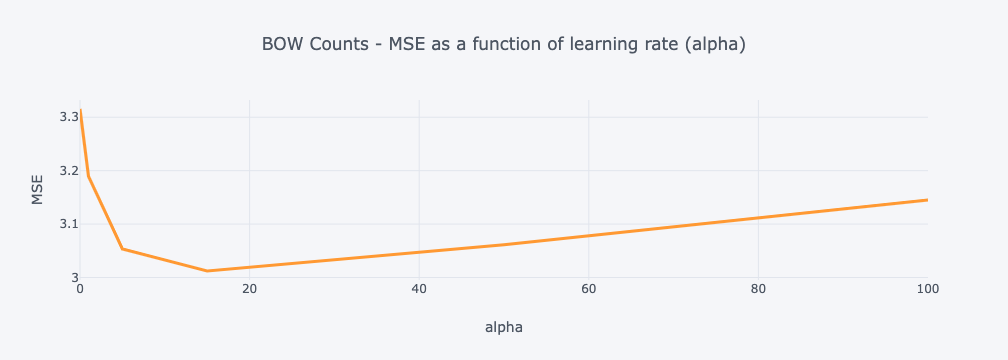

In [84]:
cv_results = pd.DataFrame(auc_by_alpha, columns = ['alpha', 'MSE'])
fig=cv_results.query('alpha <= 100').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of learning rate (alpha)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [85]:
opt_alpha, min_mse = cv_results.loc[cv_results.MSE.idxmin()]
print(opt_alpha, min_mse)

15.0 3.0121783482544187


In [86]:
model = Ridge( alpha=opt_alpha,max_iter=10000,tol=0.00001)
model.fit(train_united_features, train_data.points)

Ridge(alpha=15.0, max_iter=10000, tol=1e-05)

In [87]:
test_data['predicted_score_by_both']= model.predict(test_united_features)

In [133]:
bowf_stats = calc_prediction_quality(test_data, 'predicted_score_by_both', 'points')
bowf_stats

MSE    3.013434
MAE    1.368512
R2     0.686200
dtype: float64

## Deep Learning approaches

### Fully connected network on the text only

#### Tokenization

In [135]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [136]:
wine_reviews['description_clean'] = leave_language_only(wine_reviews.description.str.lower())

In [137]:
wine_reviews.description_clean.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    68.0
0.99    81.0
Name: description_clean, dtype: float64

In [138]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [139]:
vectorize_layer.adapt(train_data['description_clean'])

In [140]:
sample_description = train_data['description_clean'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

lots of ripe  forward citrus  tropical fruit  melon and peach flavors in this slightly sweet sauvignon blanc  a bit of oak brings a nice smoky creaminess  more controversial is the green  gooseberry tartness that will divide wine lovers into pro and con 


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([  404,     5,    27,   354,    61,   210,    16,   179,     2,
          79,    10,    11,     7,   150,    53,    91,   255,     4,
         120,     5,    42,   318,     4,   266,   169,  1280,    68,
        7702,     8,     3,    77,   967,  1138,    19,    84, 10483,
           9,  2081,   108,  9333,     2,  9680,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])>

In [141]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

404 --->  lots
5 --->  of
27 --->  ripe
354 --->  forward
61 --->  citrus
210 --->  tropical
16 --->  fruit
179 --->  melon
2 --->  and
79 --->  peach
10 --->  flavors
11 --->  in
7 --->  this
150 --->  slightly
53 --->  sweet
91 --->  sauvignon
255 --->  blanc
4 --->  a
120 --->  bit
5 --->  of


#### Modeling

In [142]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [143]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout_4 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                

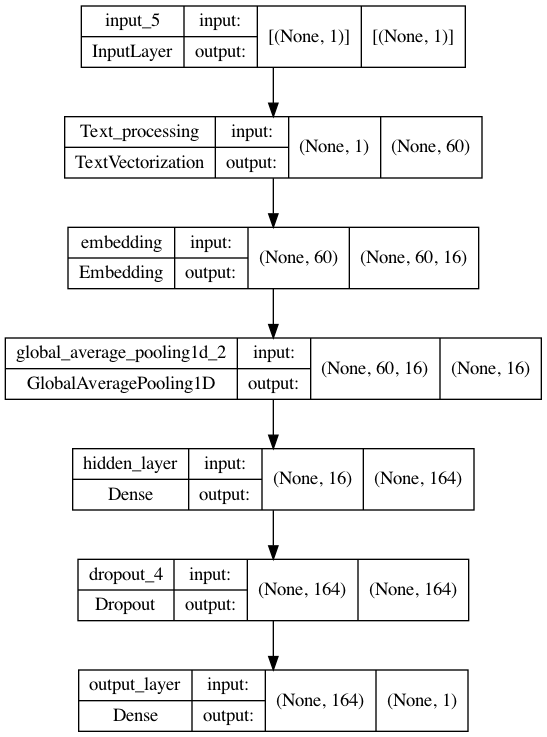

In [144]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [145]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [146]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 22.0045 - mean_squared_error: 1360.6184 - mean_absolute_error: 22.0045 - val_loss: 2.4706 - val_mean_squared_error: 9.2027 - val_mean_absolute_error: 2.4706
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 3.4415 - mean_squared_error: 18.5775 - mean_absolute_error: 3.4415 - val_loss: 1.7236 - val_mean_squared_error: 4.6598 - val_mean_absolute_error: 1.7236
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 3.1687 - mean_squared_error: 15.8480 - mean_absolute_error: 3.1687 - val_loss: 1.5280 - val_mean_squared_error: 3.7224 - val_mean_absolute_error: 1.5280
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 3.1245 - mean_squared_error: 15.3364 - mean_absolute_error: 3.1245 - val_loss: 1.4768 - val_mean_squared_error: 3.4951 - val_mean_absolute_error: 1.4768
Epoch 5/20
750/750 [==============================] - 3s 5ms/step - loss: 3.0937 - mean_

### Simple NN Prediction & Evaluation

In [147]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [148]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    3.052601
MAE    1.379098
R2     0.682122
dtype: float64

### Descriptions words concatinated

In [149]:
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [150]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [151]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

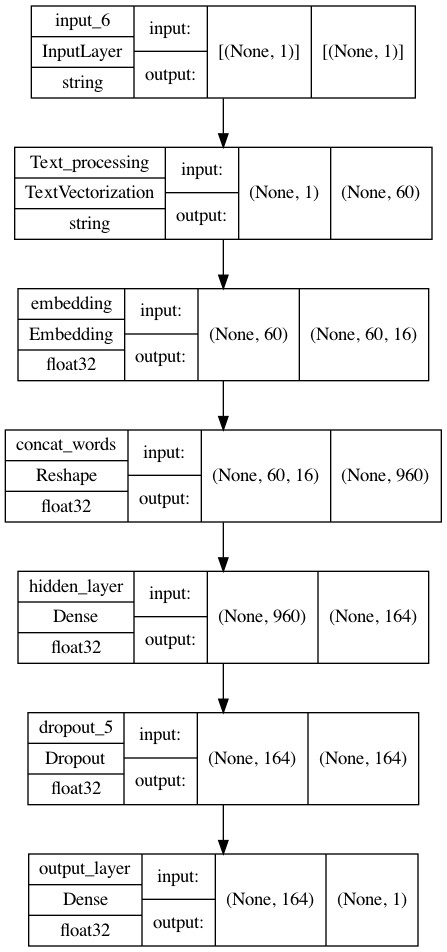

In [152]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [155]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 8.1384 - mean_squared_error: 104.1044 - mean_absolute_error: 8.1384 - val_loss: 1.7779 - val_mean_squared_error: 5.0133 - val_mean_absolute_error: 1.7779
Epoch 2/20
750/750 [==============================] - 4s 5ms/step - loss: 8.1199 - mean_squared_error: 103.3653 - mean_absolute_error: 8.1199 - val_loss: 1.9017 - val_mean_squared_error: 5.6994 - val_mean_absolute_error: 1.9017
Epoch 3/20
750/750 [==============================] - 4s 5ms/step - loss: 8.0220 - mean_squared_error: 100.8974 - mean_absolute_error: 8.0220 - val_loss: 1.6635 - val_mean_squared_error: 4.4376 - val_mean_absolute_error: 1.6635
Epoch 4/20
750/750 [==============================] - 4s 5ms/step - loss: 7.9925 - mean_squared_error: 100.0751 - mean_absolute_error: 7.9925 - val_loss: 1.6645 - val_mean_squared_error: 4.4177 - val_mean_absolute_error: 1.6645
Epoch 5/20
750/750 [==============================] - 4s 5ms/step - loss: 7.9586 - mean_

In [156]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

In [157]:
concat_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
concat_stats

MSE    4.417710
MAE    1.664544
R2     0.539968
dtype: float64

### Using external embedding (description feature only)

Follow https://keras.io/examples/nlp/pretrained_word_embeddings/

You can either average the description words embeddings, concatinate them or do both and compare. 

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [159]:
f = open("data/glove.6B.100d.txt", encoding = "utf8")

In [160]:
embeddings_index = {}
for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [161]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [162]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19535 words (12465 misses)


In [164]:
print(num_tokens)
len(word_index) + 1

32002


32001

In [165]:
from tensorflow import keras
#from tensorflow.keras.layers import Embedding
from keras.layers import Dense, Embedding, Input, Activation, Dropout, GlobalAveragePooling1D

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [166]:
embedding_layer = Embedding(num_tokens, embedding_dim, weights = [embedding_matrix], trainable = False) 
int_sequences_input  = Input(shape=(1,), dtype=tf.string)
vec_layer = vectorize_layer(int_sequences_input )
embedded_sequences = embedding_layer(vec_layer) 
x = GlobalAveragePooling1D()(embedded_sequences)
x = Dense(164, activation = 'relu')(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)

In [167]:
pretrained_emb_model = keras.Model(inputs=int_sequences_input, outputs=output)

In [168]:
pretrained_emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding_1 (Embedding)     (None, 60, 100)           3200200   
                                                                 
 global_average_pooling1d_3   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 164)               16564     
                                                                 
 dropout_6 (Dropout)         (None, 164)               0     

In [169]:
pretrained_emb_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

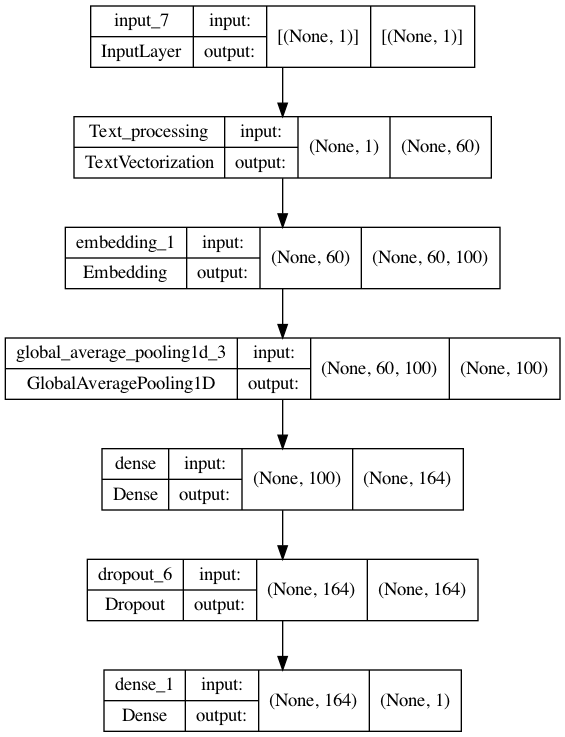

In [170]:
tf.keras.utils.plot_model(pretrained_emb_model, show_dtype=False, show_shapes=True, show_layer_names=True)

In [173]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = pretrained_emb_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 24.2450 - mean_squared_error: 1150.2682 - mean_absolute_error: 24.2450 - val_loss: 11.9859 - val_mean_squared_error: 220.2822 - val_mean_absolute_error: 11.9859
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 9.3048 - mean_squared_error: 138.7807 - mean_absolute_error: 9.3048 - val_loss: 5.3807 - val_mean_squared_error: 45.1520 - val_mean_absolute_error: 5.3807
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 3.9033 - mean_squared_error: 25.0495 - mean_absolute_error: 3.9033 - val_loss: 1.9146 - val_mean_squared_error: 5.7946 - val_mean_absolute_error: 1.9146
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 3.2090 - mean_squared_error: 16.2470 - mean_absolute_error: 3.2090 - val_loss: 1.8791 - val_mean_squared_error: 5.5809 - val_mean_absolute_error: 1.8791
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 3.1596 -

In [174]:
test_data['ext_emb_prediction'] = pretrained_emb_model.predict(test_data[text_col])

In [176]:
ext_emb_stats = calc_prediction_quality(test_data, 'ext_emb_prediction', target_col)
ext_emb_stats

MSE    5.031617
MAE    1.784432
R2     0.476040
dtype: float64

### Using LSTM or RNN Layer, (description feature only)

See example here: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [178]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras import Sequential

In [179]:
embedding_dim=16
units=160

lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding", ),
    LSTM(units),
    Dense(164, activation='relu', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [180]:
lstm_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [181]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm (LSTM)                 (None, 160)               113280    
                                                                 
 hidden_layer (Dense)        (None, 164)               26404     
                                                                 
 dropout_7 (Dropout)         (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 165       
                                                      

In [182]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = lstm_model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 76s 98ms/step - loss: 7.6057 - mean_squared_error: 250.0398 - mean_absolute_error: 7.6057 - val_loss: 2.5693 - val_mean_squared_error: 9.9154 - val_mean_absolute_error: 2.5693
Epoch 2/20
750/750 [==============================] - 74s 99ms/step - loss: 4.5949 - mean_squared_error: 33.0060 - mean_absolute_error: 4.5949 - val_loss: 2.5188 - val_mean_squared_error: 9.7013 - val_mean_absolute_error: 2.5188
Epoch 3/20
750/750 [==============================] - 73s 97ms/step - loss: 4.5924 - mean_squared_error: 33.0083 - mean_absolute_error: 4.5924 - val_loss: 2.5337 - val_mean_squared_error: 9.5674 - val_mean_absolute_error: 2.5337
Epoch 4/20
750/750 [==============================] - 75s 100ms/step - loss: 4.6053 - mean_squared_error: 33.1895 - mean_absolute_error: 4.6053 - val_loss: 2.6168 - val_mean_squared_error: 10.5421 - val_mean_absolute_error: 2.6168
CPU times: user 13min 18s, sys: 4min 42s, total: 18min 1s
Wall time: 4min 57s


In [183]:
test_data['lstm_prediction'] = lstm_model.predict(test_data[text_col])

In [185]:
lstm_stats = calc_prediction_quality(test_data, 'lstm_prediction', target_col)
lstm_stats

MSE    9.701329
MAE    2.518778
R2    -0.010234
dtype: float64

In [186]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, bow_stats, bowf_stats, dnn_stats, concat_stats, lstm_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb','nlp', 'nlp_all', 'dnn','dnn_concat','lstm'])
all_compared

MSE       MAE        R2
baseline_1         9.603218  2.537841 -0.000018
baseline_2         9.130190  2.471840  0.049241
baseline_3         8.589486  2.376368  0.105546
regression_by_xgb  6.410284  1.907826  0.332474
nlp                3.009492  1.367681  0.686611
nlp_all            3.013434  1.368512  0.686200
dnn                3.052601  1.379098  0.682122
dnn_concat         4.417710  1.664544  0.539968
lstm               9.701329  2.518778 -0.010234

In [187]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Bonus (Not mandatory) Use all features using Keras functional API

See here: https://keras.io/guides/functional_api/

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

Select encoded features for train

In [188]:
train_encoded = train_encoded_features.iloc[:,:-1]
train_encoded.head(1)

country  province  region_1  region_2  taster_name  variety  winery  price
1       32       108       738         6           16      451   12956   15.0

Select encoded features for test

In [190]:
test_encoded = test_encoded_features.iloc[:,:-2]
test_encoded.head(1)

country  province  region_1  region_2  taster_name  variety  winery  price
0       22       332       424         6            9      691   11608   -1.0

importing libraries

In [191]:
from tensorflow.keras import Model
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, GlobalAveragePooling1D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import concatenate

In [192]:
text_features_input = Input(shape=(1,), dtype=tf.string)
vect_layer = vectorize_layer(text_features_input)
embeddding_layer = Embedding(vocab_size, embedding_dim, name="embedding", )(vect_layer)
concat_layer = Reshape((embedding_dim * sequence_length, ), name='concat_words')(embeddding_layer)
hidden_layer1 = Dense(200, activation='relu', name='hidden_layer1')(concat_layer)

country_input = Input(shape = (1,))
province_input = Input(shape = (1,))
region_1_input = Input(shape = (1,))
region_2_input = Input(shape = (1,))
taster_name_input = Input(shape = (1,))
variety_input = Input(shape = (1,))
winery_input = Input(shape = (1,))
price_input = Input(shape = (1,))

other_features = concatenate([country_input,province_input,region_1_input,region_2_input,taster_name_input,variety_input,winery_input,price_input])

hidden_layer2 = Dense(200, activation='relu', name='hidden_layer2')(other_features)

merge = concatenate([hidden_layer1,hidden_layer2])

hidden_layer3 = Dense(200, activation='relu', name='hidden_layer3')(merge)
reg_layer = Dropout(0.3)(hidden_layer3)
output = Dense(1)(reg_layer)

In [193]:
api_model = Model(inputs = [text_features_input,country_input,province_input,region_1_input,region_2_input,taster_name_input,variety_input,winery_input,price_input] , outputs = output)


In [194]:
api_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Text_processing (TextVectoriza  (None, 60)          0           ['input_10[0][0]']               
 tion)                                                                                            
                                                                                                  
 embedding (Embedding)          (None, 60, 16)       512000      ['Text_processing[4][0]']        
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                         

In [195]:
api_model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

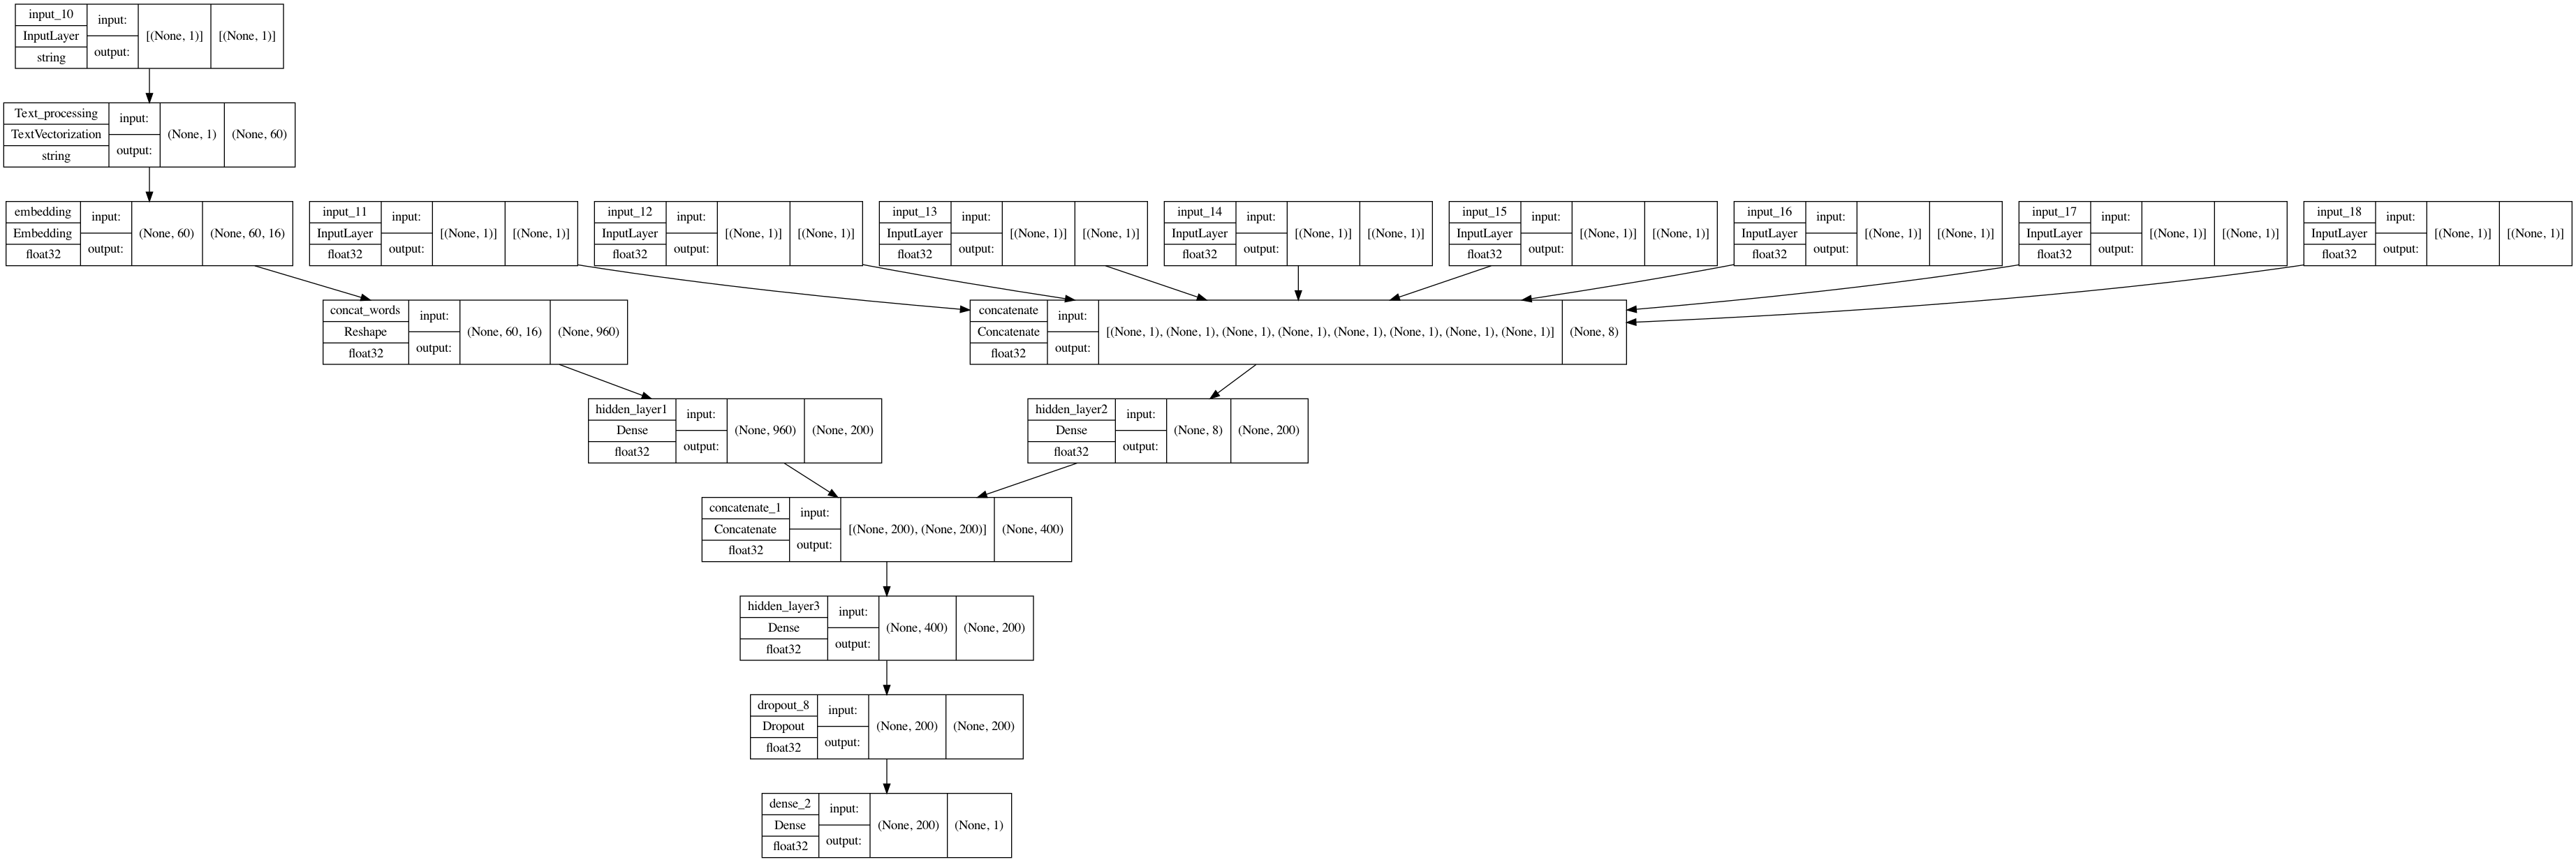

In [196]:
tf.keras.utils.plot_model(api_model, show_dtype=True, show_shapes=True, show_layer_names=True)


In [197]:
train_encoded.shape

(95990, 8)

In [199]:
train_data.shape

(95990, 14)

In [200]:
test_encoded.shape

(23998, 8)

In [201]:
test_data.shape

(23998, 21)

In [202]:
text_train = train_data['description_clean']
country_train = train_encoded['country']
province_train = train_encoded['province']
region_1_train = train_encoded['region_1']
region_2_train = train_encoded['region_2']
taster_name_train = train_encoded['taster_name']
variety_train = train_encoded['variety']
winery_train = train_encoded['winery']
price_train = train_encoded['price']

In [203]:
text_test = test_data['description_clean']
country_test = test_encoded['country']
province_test = test_encoded['province']
region_1_test = test_encoded['region_1']
region_2_test= test_encoded['region_2']
taster_name_test = test_encoded['taster_name']
variety_test = test_encoded['variety']
winery_test = test_encoded['winery']
price_test = test_encoded['price']

In [205]:
%%time
text_col, target_col = 'description_clean', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = api_model.fit(
    [text_train,country_train,province_train,region_1_train,region_2_train,taster_name_train,variety_train,winery_train,price_train],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = ([text_test,country_test,province_test,region_1_test,region_2_test,taster_name_test,variety_test,\
                        winery_test,price_test], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 19.7052 - mean_squared_error: 3651.8381 - mean_absolute_error: 19.7052 - val_loss: 8.3475 - val_mean_squared_error: 85.8282 - val_mean_absolute_error: 8.3475
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 9.4897 - mean_squared_error: 141.9702 - mean_absolute_error: 9.4897 - val_loss: 3.5836 - val_mean_squared_error: 19.7594 - val_mean_absolute_error: 3.5836
Epoch 3/20
750/750 [==============================] - 7s 9ms/step - loss: 8.7450 - mean_squared_error: 120.2302 - mean_absolute_error: 8.7450 - val_loss: 2.3589 - val_mean_squared_error: 8.9636 - val_mean_absolute_error: 2.3589
Epoch 4/20
750/750 [==============================] - 6s 9ms/step - loss: 8.5034 - mean_squared_error: 113.8297 - mean_absolute_error: 8.5034 - val_loss: 2.4142 - val_mean_squared_error: 9.2032 - val_mean_absolute_error: 2.4142
Epoch 5/20
750/750 [==============================] - 6s 8ms/step - loss: 8.3717 - 

In [207]:
test_data['api_prediction'] = api_model.predict([text_test,country_test,province_test,region_1_test,region_2_test,\
                                                 taster_name_test,variety_test,winery_test,price_test])

In [209]:
api_stats = calc_prediction_quality(test_data, 'api_prediction', target_col)
api_stats

MSE    8.963567
MAE    2.358948
R2     0.066592
dtype: float64

In [211]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats, bow_stats, bowf_stats, dnn_stats, concat_stats,\
                             lstm_stats, api_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb',\
                                                            'nlp', 'nlp_all', 'dnn','dnn_concat','lstm', 'functional_api'])
all_compared

MSE       MAE        R2
baseline_1         9.603218  2.537841 -0.000018
baseline_2         9.130190  2.471840  0.049241
baseline_3         8.589486  2.376368  0.105546
regression_by_xgb  6.410284  1.907826  0.332474
nlp                3.009492  1.367681  0.686611
nlp_all            3.013434  1.368512  0.686200
dnn                3.052601  1.379098  0.682122
dnn_concat         4.417710  1.664544  0.539968
lstm               9.701329  2.518778 -0.010234
functional_api     8.963567  2.358948  0.066592

In [212]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

### Conclusion

according to both MSE and MAE, most basic NLP with just the description gives the best results.